# Command Recognition using keywords

## 1. Importing Dependencies

In [99]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [100]:
# A seed can be used to reproduce results
SEED = 128
tf.random.set_seed(SEED)
np.random.seed(SEED)

### 1.1 Global Variables

In [101]:
SAMPLING_RATE = 16000 #16 kHz

## 2. Loading the Dataset

In [102]:
DATASET_PATH = 'Data\mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH) # Converts string to file path based on OS

# Creates the directroy and downloads dataset if not made yet
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='Data')

### 2.1 Splitting the dataset

Splits dataset into batches of audio clips with their respective integer labels

In [103]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.3, # 30% used as validation/test set, will be split again later
    seed=SEED,
    output_sequence_length=16000, # Keeps all audio clips at one second
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 5600 files for training.
Using 2400 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Audio clips are in the shape of (Batch, Samples, Channels). Since there is only one channel, the channel dimension is redundant and can be eliminated

In [104]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

# Using tf.data.AUTOTUNE as a parameter for num_parallel_calls to dynamically adjust processing based on CPU/GPU usage
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

Showing shape of the batches

In [105]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Split the Validation set into a seperate validation and test set, both comprising of 15% of the total dataset

In [106]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

Plots waveforms of first n samples of training data

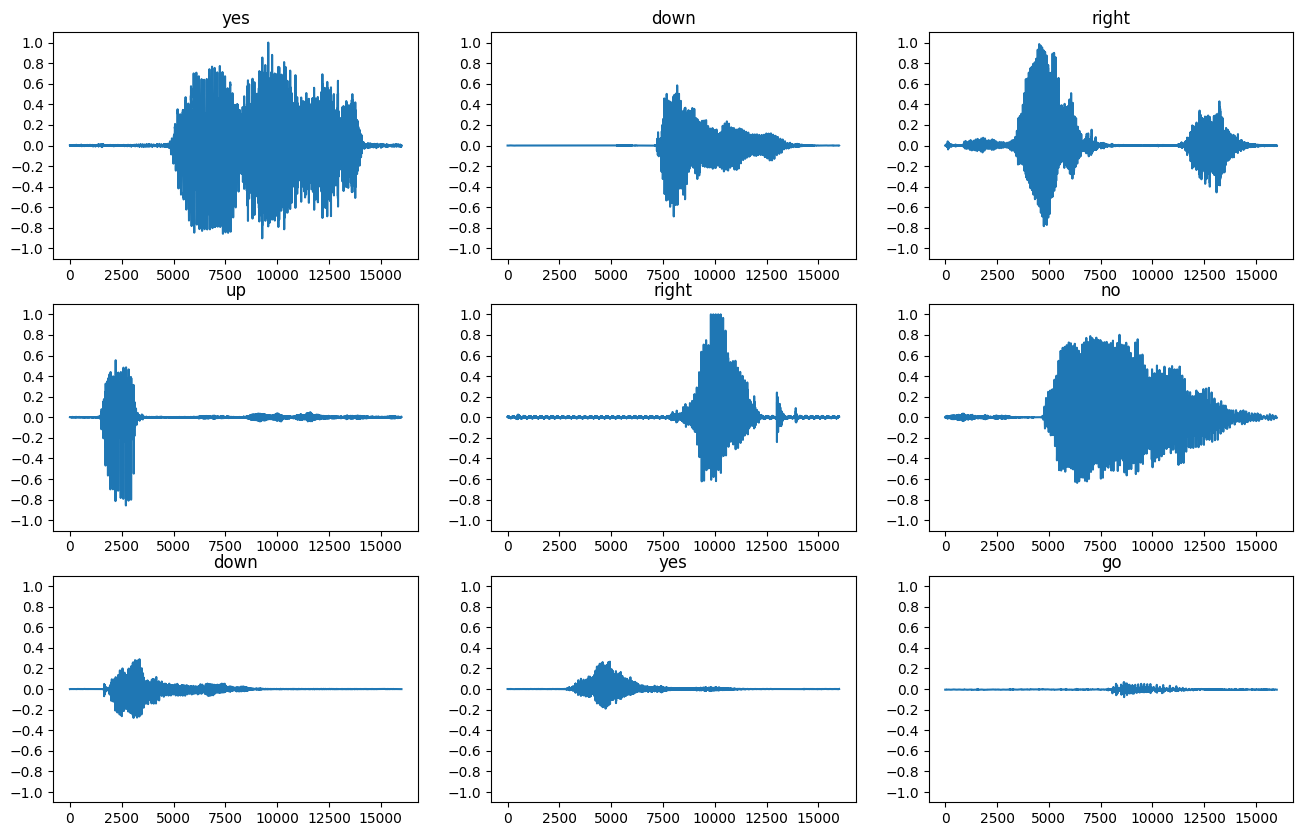

In [107]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

## 3. Processing Data

### 3.1 Visualizing Waveforms as Magnitude Spectrums

In [108]:
def FFT(audio, label):
    tf.signal.fft(tf.complex(audio, 0.0))
    return audio, label

In [109]:
train_fft = train_ds.map(FFT, tf.data.AUTOTUNE)

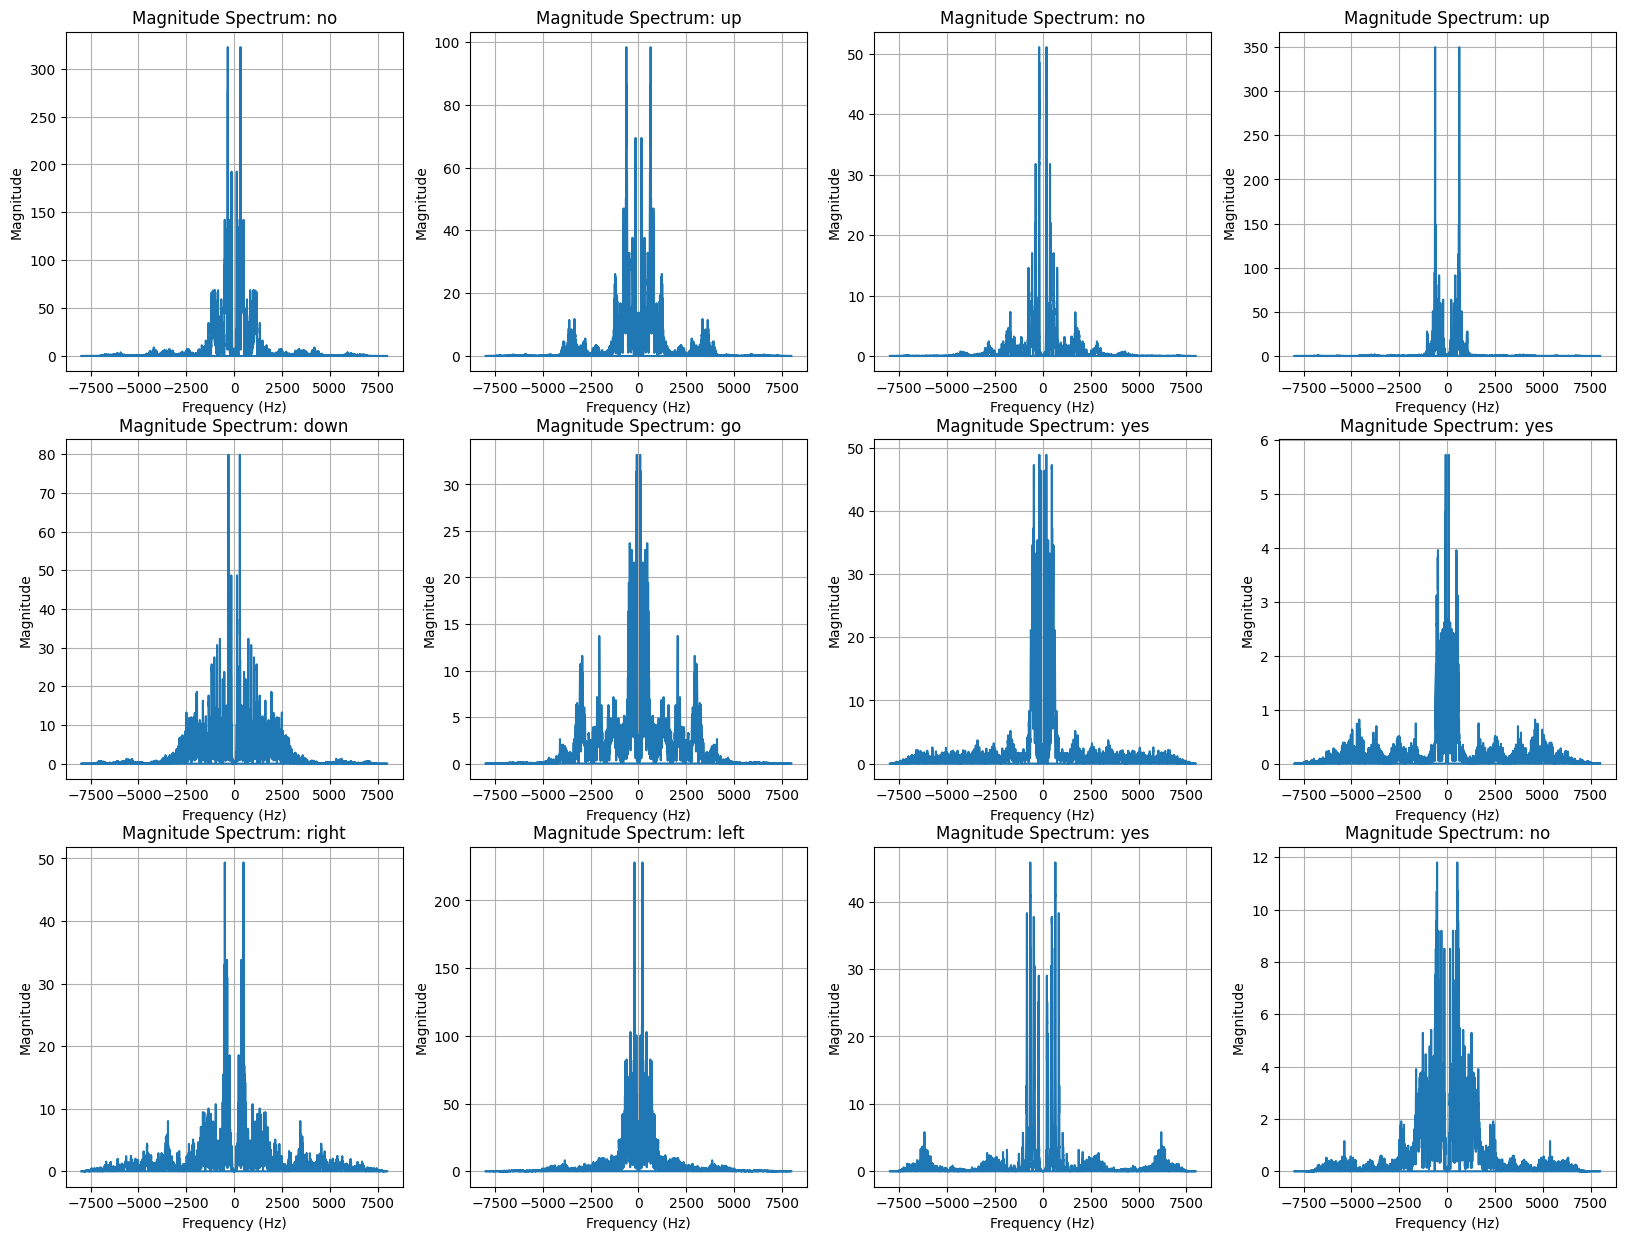

In [118]:
m = 3 # Number of rows
n = 4 # Number of columns

for example_audio, example_labels in train_fft.take(1):
    pass

# Create subplots
fig, axes = plt.subplots(m, n, figsize=(20, 15))

for i in range(n*m):
    # Apply FFT
    fft_output = tf.signal.fft(tf.complex(example_audio[i], 0.0))

    # Get frequency bins
    frequency_bins = np.fft.fftfreq(len(fft_output), 1 / SAMPLING_RATE)

    # Plot the spectrum (magnitude spectrum) in the corresponding subplot
    ax = axes[i // n, i % n]  # Calculate subplot index
    ax.plot(frequency_bins, np.abs(fft_output))
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude')
    ax.set_title(f'Magnitude Spectrum: {label_names[example_labels[i]]}')
    ax.grid(True)

### 3.2 Visualizing the Waveforms as Spectrograms

In [111]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [112]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [113]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

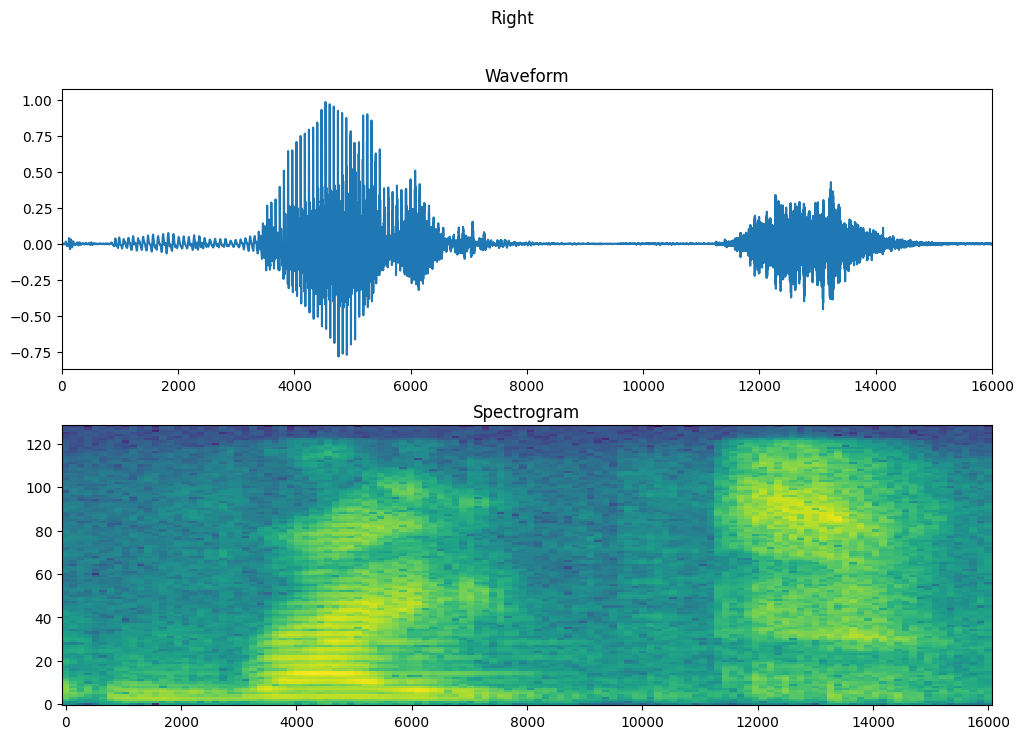

In [114]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Make models using FFT and STFT as inputs and compare results. Alter hyperparameters to try and improve performance and compare. Try and use the best model to get real time feedback from commands. Maybe feed raw wav forms through the model and compare the results